In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/Implementation/aqua/aquaphonics/dataset.zip -d .

In [3]:
# import the necessary packages
import h5py
import os

class HDF5DatasetWriter:
	def __init__(self, dims, outputPath, dataKey="images",
		bufSize=1000):
		# check to see if the output path exists, and if so, raise
		# an exception
		if os.path.exists(outputPath):
			raise ValueError("The supplied `outputPath` already "
				"exists and cannot be overwritten. Manually delete "
				"the file before continuing.", outputPath)

		# open the HDF5 database for writing and create two datasets:
		# one to store the images/features and another to store the
		# class labels
		self.db = h5py.File(outputPath, "w")
		self.data = self.db.create_dataset(dataKey, dims,
			dtype="float")
		self.labels = self.db.create_dataset("labels", (dims[0],),
			dtype="int")

		# store the buffer size, then initialize the buffer itself
		# along with the index into the datasets
		self.bufSize = bufSize
		self.buffer = {"data": [], "labels": []}
		self.idx = 0

	def add(self, rows, labels):
		# add the rows and labels to the buffer
		self.buffer["data"].extend(rows)
		self.buffer["labels"].extend(labels)

		# check to see if the buffer needs to be flushed to disk
		if len(self.buffer["data"]) >= self.bufSize:
			self.flush()

	def flush(self):
		# write the buffers to disk then reset the buffer
		i = self.idx + len(self.buffer["data"])
		self.data[self.idx:i] = self.buffer["data"]
		self.labels[self.idx:i] = self.buffer["labels"]
		self.idx = i
		self.buffer = {"data": [], "labels": []}

	def storeClassLabels(self, classLabels):
		# create a dataset to store the actual class label names,
		# then store the class labels
		dt = h5py.special_dtype(vlen=str) # `vlen=unicode` for Py2.7
		labelSet = self.db.create_dataset("label_names",
			(len(classLabels),), dtype=dt)
		labelSet[:] = classLabels

	def close(self):
		# check to see if there are any other entries in the buffer
		# that need to be flushed to disk
		if len(self.buffer["data"]) > 0:
			self.flush()

		# close the dataset
		self.db.close()

### Feature Extraction

In [4]:
# import the necessary packages
from tensorflow.keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from imutils import paths
import numpy as np
import progressbar
import random
import os

In [5]:
# store the batch size in a convenience variable
bs = 16

# grab the list of images that we'll be describing then randomly
# shuffle them to allow for easy training and testing splits via
# array slicing during training time
print("[INFO] loading images...")
imagePaths = list(paths.list_images("dataset"))
random.shuffle(imagePaths)

# extract the class labels from the image paths then encode the
# labels
labels = [p.split(os.path.sep)[-2] for p in imagePaths]
le = LabelEncoder()
labels = le.fit_transform(labels)

# load the VGG16 network
print("[INFO] loading network...")
model = VGG16(weights="imagenet", include_top=False)

# initialize the HDF5 dataset writer, then store the class label
# names in the dataset
dataset = HDF5DatasetWriter((len(imagePaths), 512 * 7 * 7),
	"features.hdf5", dataKey="features", bufSize=1000)
dataset.storeClassLabels(le.classes_)

# initialize the progress bar
widgets = ["Extracting Features: ", progressbar.Percentage(), " ",
	progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval=len(imagePaths),
	widgets=widgets).start()

# loop over the images in patches
for i in np.arange(0, len(imagePaths), bs):
	# extract the batch of images and labels, then initialize the
	# list of actual images that will be passed through the network
	# for feature extraction
	batchPaths = imagePaths[i:i + bs]
	batchLabels = labels[i:i + bs]
	batchImages = []

	# loop over the images and labels in the current batch
	for (j, imagePath) in enumerate(batchPaths):
		# load the input image using the Keras helper utility
		# while ensuring the image is resized to 224x224 pixels
		image = load_img(imagePath, target_size=(224, 224))
		image = img_to_array(image)

		# preprocess the image by (1) expanding the dimensions and
		# (2) subtracting the mean RGB pixel intensity from the
		# ImageNet dataset
		image = np.expand_dims(image, axis=0)
		image = imagenet_utils.preprocess_input(image)

		# add the image to the batch
		batchImages.append(image)

	# pass the images through the network and use the outputs as
	# our actual features
	batchImages = np.vstack(batchImages)
	features = model.predict(batchImages, batch_size=bs)

	# reshape the features so that each image is represented by
	# a flattened feature vector of the `MaxPooling2D` outputs
	features = features.reshape((features.shape[0], 512 * 7 * 7))

	# add the features and labels to our HDF5 dataset
	dataset.add(features, batchLabels)
	pbar.update(i)

# close the dataset
dataset.close()
pbar.finish()

[INFO] loading images...
[INFO] loading network...
58900480/58889256 [==============================] - 0s 0us/step


Extracting Features: 100% |####################################| Time:  0:00:22


In [23]:
# import the necessary packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import pickle
import h5py

# open the HDF5 database for reading then determine the index of
# the training and testing split, provided that this data was
# already shuffled *prior* to writing it to disk
db = h5py.File('features.hdf5', "r")
i = int(db["labels"].shape[0] * 0.75)


### Decision Tree

In [19]:
classNames = ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot',
              'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus',
              'healthy', 'mosaic_virus']

In [20]:

# train and evaluate decision_tree classifier on the raw pixel intensities
print("[INFO] evaluating Decision_Tree classifier...")
model = DecisionTreeClassifier()
model.fit(db["features"][:i], db["labels"][:i])

# evaluate the model
print("[INFO] evaluating...")
preds = model.predict(db["features"][i:])
print(classification_report(db["labels"][i:], preds,
	target_names=classNames))

class accu_dt():
	print(cross_val_score(model, db["features"], db["labels"], scoring="accuracy", cv = 7).mean())
accu_dt()

# serialize the model to disk
print("[INFO] saving model...")
f = open('decision_tree.p', "wb")
f.write(pickle.dumps(model))
f.close()

[INFO] evaluating Decision_Tree classifier...
[INFO] evaluating...
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.48      0.44      0.46        27
                        Early_blight       0.68      0.68      0.68        28
                         Late_blight       0.78      0.75      0.77        24
                           Leaf_Mold       0.55      0.50      0.52        22
                  Septoria_leaf_spot       0.71      0.74      0.72        23
Spider_mites Two-spotted_spider_mite       0.67      0.72      0.69        25
                         Target_Spot       0.52      0.54      0.53        26
       Tomato_Yellow_Leaf_Curl_Virus       0.75      0.54      0.63        28
                             healthy       0.65      0.68      0.67        25
                        mosaic_virus       0.47      0.64      0.54        22

                            accuracy                           0.62      

### K-Nearest Neighbour

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# train and evaluate a k-NN classifier on the raw pixel intensities
print("[INFO] evaluating k-NN classifier...")
model = KNeighborsClassifier(n_neighbors=1,
	n_jobs=1)
model.fit(db["features"][:i], db["labels"][:i])

# evaluate the model
print("[INFO] evaluating...")
preds = model.predict(db["features"][i:])
print(classification_report(db["labels"][i:], preds,
	target_names=classNames))

def accu_knn():
 print(cross_val_score(model, db["features"], db["labels"], scoring="accuracy", cv = 7).mean())
accu_knn()
# serialize the model to disk
print("[INFO] saving model...")
f = open('knn.p', "wb")
f.write(pickle.dumps(model))
f.close()


[INFO] evaluating k-NN classifier...
[INFO] evaluating...
                                      precision    recall  f1-score   support

                      Bacterial_spot       1.00      0.89      0.94        27
                        Early_blight       0.93      0.89      0.91        28
                         Late_blight       1.00      0.96      0.98        24
                           Leaf_Mold       1.00      0.86      0.93        22
                  Septoria_leaf_spot       1.00      0.91      0.95        23
Spider_mites Two-spotted_spider_mite       1.00      0.84      0.91        25
                         Target_Spot       1.00      0.69      0.82        26
       Tomato_Yellow_Leaf_Curl_Virus       1.00      0.89      0.94        28
                             healthy       0.45      1.00      0.62        25
                        mosaic_virus       1.00      0.73      0.84        22

                            accuracy                           0.87       250
    

### Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
# train and evaluate random_forest classifier on the raw pixel intensities
print("[INFO] evaluating Random_Forest classifier...")
model = RandomForestClassifier(n_estimators=100)
model.fit(db["features"][:i], db["labels"][:i])

# evaluate the model
print("[INFO] evaluating...")
preds = model.predict(db["features"][i:])
print(classification_report(db["labels"][i:], preds,
	target_names=classNames))

def accu_rf():
	print(cross_val_score(model, db["features"], db["labels"], scoring="accuracy", cv = 7).mean())
accu_rf()

# serialize the model to disk
print("[INFO] saving model...")
f = open('random_forest.p', "wb")
f.write(pickle.dumps(model))
f.close()


[INFO] evaluating Random_Forest classifier...
[INFO] evaluating...
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.86      0.93      0.89        27
                        Early_blight       0.92      0.82      0.87        28
                         Late_blight       0.96      1.00      0.98        24
                           Leaf_Mold       1.00      0.95      0.98        22
                  Septoria_leaf_spot       1.00      1.00      1.00        23
Spider_mites Two-spotted_spider_mite       0.86      1.00      0.93        25
                         Target_Spot       1.00      0.85      0.92        26
       Tomato_Yellow_Leaf_Curl_Virus       1.00      1.00      1.00        28
                             healthy       1.00      1.00      1.00        25
                        mosaic_virus       0.96      1.00      0.98        22

                            accuracy                           0.95      

### Support Vector Machine

In [25]:
from sklearn import svm
# train and evaluate svm classifier on the raw pixel intensities
print("[INFO] evaluating SVM classifier...")
model = svm.SVC(kernel='linear')
model.fit(db["features"][:i], db["labels"][:i])

# evaluate the model
print("[INFO] evaluating...")
preds = model.predict(db["features"][i:])
print(classification_report(db["labels"][i:], preds,
	target_names=classNames))

def accu_svm():
	print(cross_val_score(model, db["features"], db["labels"], scoring="accuracy", cv = 7).mean())

# serialize the model to disk
print("[INFO] saving model...")
f = open('svm.p', "wb")
f.write(pickle.dumps(model))
f.close()

[INFO] evaluating SVM classifier...
[INFO] evaluating...
                                      precision    recall  f1-score   support

                      Bacterial_spot       1.00      1.00      1.00        27
                        Early_blight       1.00      1.00      1.00        28
                         Late_blight       1.00      1.00      1.00        24
                           Leaf_Mold       1.00      1.00      1.00        22
                  Septoria_leaf_spot       1.00      1.00      1.00        23
Spider_mites Two-spotted_spider_mite       1.00      1.00      1.00        25
                         Target_Spot       1.00      1.00      1.00        26
       Tomato_Yellow_Leaf_Curl_Virus       1.00      1.00      1.00        28
                             healthy       1.00      1.00      1.00        25
                        mosaic_virus       1.00      1.00      1.00        22

                            accuracy                           1.00       250
     

### Prediction

[INFO] loading image...
[INFO] loading network...
[INFO] loading pre-trained network...
[INFO] predicting...
[INFO] Label: healthy


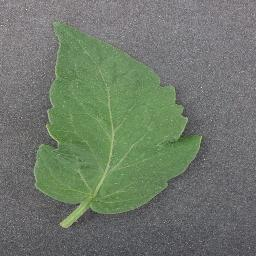

In [41]:
# import the necessary packages
from google.colab.patches import cv2_imshow
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
import numpy as np
import cv2

db = h5py.File("features.hdf5", "r")

# grab the image
print("[INFO] loading image...")
orig = cv2.imread('1.JPG')
imagePath = orig.copy()

# load the VGG16 network
print("[INFO] loading network...")
model = VGG16(weights="imagenet", include_top=False)

# image is resized to 224x224 pixels
image  =cv2.resize(imagePath, (224, 224))
image = img_to_array(image)

# preprocess the image by (1) expanding the dimensions and
# (2) subtracting the mean RGB pixel intensity from the
# ImageNet dataset
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)

# pass the images through the network and use the outputs as
# our actual features
features = model.predict(image)

# reshape the features so that each image is represented by
# a flattened feature vector of the `MaxPooling2D` outputs
features = features.reshape((features.shape[0], 512 * 7 * 7))

# load the pre-trained network
print("[INFO] loading pre-trained network...")
loaded_model = pickle.load(open("svm.p", 'rb'))

# make predictions on the images
print("[INFO] predicting...")
preds = loaded_model.predict(features)

# getting predicted image
cv2.putText(image, "Label: {}".format(db["label_names"][preds]),
	(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

print('[INFO] Label:', classNames[preds[0]])
cv2_imshow(orig)